In [25]:
## Usefull imports
from IPython import display
from abipy.flowtk.lumi_works import LumiWork
from deltaSCF import DeltaSCF
from lineshape import Lineshape
from abipy.abilab import abiopen
from abipy.dfpt import phonons

%matplotlib inline
from matplotlib import pyplot as plt

# LumiWork tutorial 
1st version, 25/08/2021


This tutorial aims at showing how to use the LumiWork scripts and how to post-process the results.


**/!\ Caution /!\** 
This tutorial does not cover how to use the whole AbiPy workflows machinery to automate Abinit computations (scheduler, manager,...). Please, refer to the tutorials available on :
- https://abinit.github.io/abipy/ 
- https://github.com/abinit/abitutorials/tree/master/abitutorials (in particular structure.ipynb, abinit_input.ipynb, flows.ipynb ) 


The theory and equations behind what will be presented can be found in the reference :

Bouquiaux, J., Poncé, S., Jia, Y., Miglio, A., Mikami, M., Gonze, X., Importance of Long-Range Channel Sr Displacements for the Narrow Emission in Sr[Li$_2$Al$_2$O$_2$N$_2$]:Eu$^{2+}$  Phosphor. Adv. Optical Mater. 2021, 2100649. https://doi.org/10.1002/adom.202100649


### Recap

Our goal is to compute the photo-luminescent properties of an impurity embedded in a lattice. Here we will take the example of the red phosphor material Sr[Li$_2$Al$_2$O$_2$N$_2$]:Eu$^{2+}$, SALON, (example of the above-mentionned paper).

With DFT, we want to compute the four states (energies + atomic structures + eventually the electronic band structures) highlighted in the figure below :

1. Relaxed ground state (A$_g$ )
2. Unrelaxed excited state (A$_g$$^*$)
3. Relaxed excited state (A$_e$$^*$)
4. Unrelaxed ground state (A$_e$ )

This requires two relaxations (one in the ground and excited state) and four SCF computations (at each state) and eventually four additional NSCF computations for the band structures. These 6 (+4) computations are automatized in one "**LumiWork**". This is coded with the lumi_works.py script.

The exicted state configuration is computed following the $\Delta$SCF-constrained occupation method, where the first unoccupied state of the ground state is force to be occupied in the excited state. On Abinit, the variable "occ" reads like :
- ground state : occ  1 1 1 0 0 0 0 
- excited state : occ  1 1 0 1 0 0 0


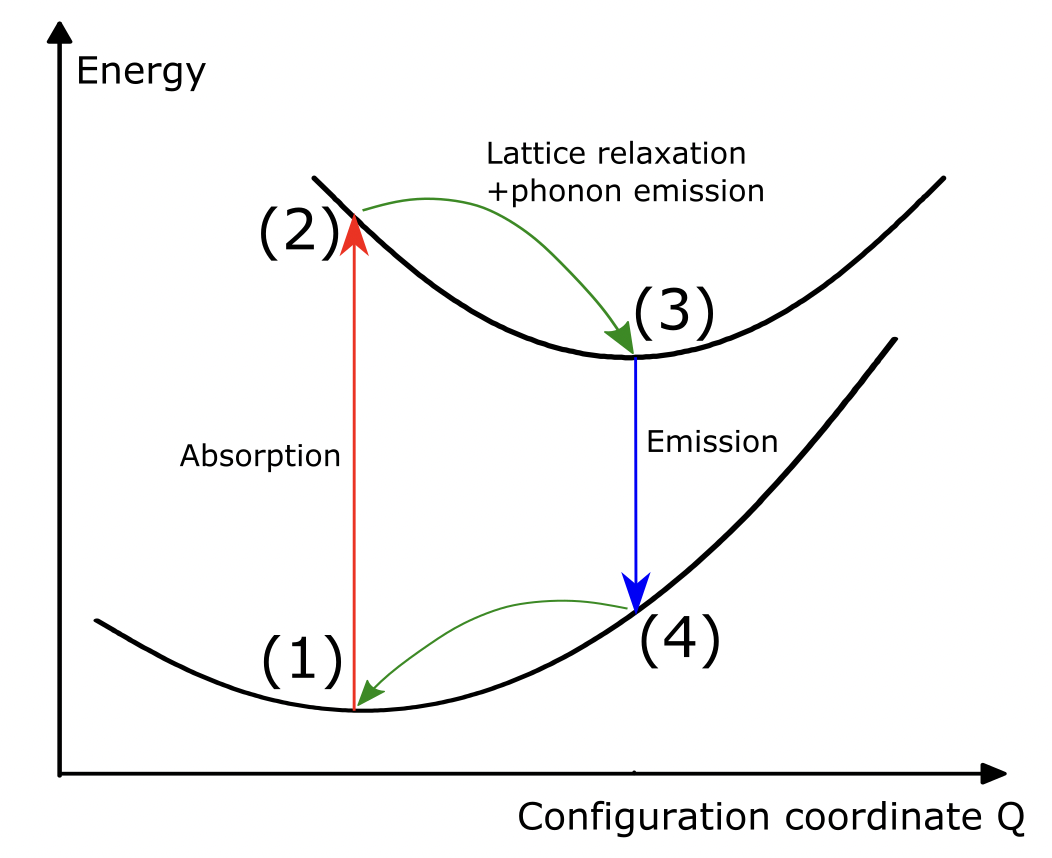

In [26]:
display.Image("IMG/CCM.png",width=400)


##  The lumi_works.py script

This script should be c/c in the abipy/flowtk/ directory

The creation of one LumiWork is done with the class method from_scf_inputs(), the documentation is c/c below :






```python

class LumiWork(Work):
    """
    This Work implements Fig 1 of https://arxiv.org/abs/2010.00423.

    Client code is responsible for the preparation of the supercell and
    of the GS SCF input files with the fixed electronic occupations associated to the two configurations.
    By default, the work computes the two relaxed structures and the four total energies
    corresponding to the Ag, Ag*, Ae*, Ae configurations. Optionally, one can activate the computation of
    four electronic band structures. See docstring of from_scf_inputs for further info.
    """

    @classmethod
    def from_scf_inputs(cls, gs_scf_inp, ex_scf_inp, relax_kwargs_gs, relax_kwargs_ex, ndivsm=0, nb_extra=10, tolwfr=1e-12, four_points=True, meta=None, manager=None):
        """
        Args:
            gs_scf_inp: |AbinitInput| representing a GS SCF run for the ground-state.
            ex_scf_inp: |AbinitInput| representing a GS SCF run for the excited-state.
            relax_kwargs_gs: Dictonary with input variables to be added to gs_scf_inp
                when generating input files for ground state structural relaxations.
            relax_kwargs_ex: Dictonary with input variables to be added to ex_scf_inp
                when generating input files for excited state structural relaxations.
            ndivsm: Activates the computation of band structure if different from zero.
                if > 0, it's the number of divisions for the smallest segment of the path (Abinit variable).
                if < 0, it's interpreted as the pymatgen `line_density` parameter in which the number of points
                in the segment is proportional to its length. Typical value: -20.
                This option is the recommended one if the k-path contains two high symmetry k-points that are very close
                as ndivsm > 0 may produce a very large number of wavevectors.
            nb_extra: Number of extra bands added to the input nband when computing band structures (ndivsm != 0).
            tolwfr: Tolerance of the residuals used for the NSCF band structure calculations.
            four_points : if True, compute the two relaxations and the four points energies.
                If false, only the two relaxations.
            meta : dict corresponding to the metadata of a lumiwork (supercell size, dopant type,...)
            manager: |TaskManager| of the task. If None, the manager is initialized from the config file.
        """
        
```

This class method is a container that receives mainly Abinit Input objects and dictionnaries of Abinit variables. 
The lumi_works.py script will then use these informations to do the following tasks (see also the comments of the lumi_works.py script):

1. Launch a first structural relaxation in the ground state, save the ground-state relaxed structure. 
2. Use the previous structure as the starting point for a second structural relaxation in the excited state, save the excited-state relaxated structure.
3. Launch the four SCF tasks simultaneously 
4. Launch optionnaly the four NSCF tasks
5. Save the filepaths of each computation is a json file (optional, but allow to ease later post-processing part) 



# Creating a LumiWork

A LumiWork (or a serie of LumiWork's) can be created with the run_deltaSCF.py script, an example for SALON case is c/c below. 


```python
#!/usr/bin/env python
import sys
import os
import abipy.abilab as abilab
import abipy.flowtk as flowtk
import abipy.data as abidata
from abipy.core import structure

def get_non_eq_sites(structure,replaced_atom):
    ### return a list of positions of non-equivalent sites for the replaced atom. ###
    irred=structure.spget_equivalent_atoms().eqmap # mapping from inequivalent sites to atoms sites
    positions=structure.get_symbol2indices()[replaced_atom] # get indices of the replaced atom
    
    index_different_sites=[]

    for i in positions:
        if len(irred[i]) != 0:
            index_different_sites.append(irred[i][0])
            
    return(index_different_sites)

def make_doped_supercell(prim_structure,supercell_size,replaced_atom,dopant_atom):
    #return a list of doped supercell structure, one for each non-equivalent site of the replaced atom
    my_structure=prim_structure.copy()
    my_structure.make_supercell(supercell_size)
    list_ineq_pos=get_non_eq_sites(my_structure,replaced_atom)
    
    doped_structure_list=[]
    
    for pos in list_ineq_pos:
        final_structure=my_structure.copy()    
        final_structure.replace(pos,dopant_atom)  
        doped_structure_list.append(final_structure)
    
    return doped_structure_list    


def scf_inp(structure):
    pseudodir='/home/ucl/modl/jbouq/psps_paw_pbe/'
    
    pseudos = ('Eu.GGA_PBE-JTH.xml',
               'Sr.GGA_PBE-JTH.xml',
               'Al.GGA_PBE-JTH.xml',
               'Li.GGA_PBE-JTH.xml',
               'O.GGA_PBE-JTH.xml',
               'N.GGA_PBE-JTH.xml')
    gs_scf_inp = abilab.AbinitInput(structure=structure, pseudos=pseudos,pseudo_dir=pseudodir)
    gs_scf_inp.set_vars(ecut=15,
                        pawecutdg=30,
                        chksymbreak=0,
                        diemac=5,
                        prtwf=-1,
                        nstep=100,
                        toldfe=1e-8,
                        chkprim=0,
                        )

    # Set DFT+U and spinat parameters according to chemical symbols.
    symb2spinat = {"Eu": [0, 0, 7]}
    symb2luj = {"Eu": {"lpawu": 3, "upawu": 7, "jpawu": 0.7}}

    gs_scf_inp.set_usepawu(usepawu=1, symb2luj=symb2luj)
    gs_scf_inp.set_spinat_from_symbols(symb2spinat, default=(0, 0, 0))

    n_val = gs_scf_inp.num_valence_electrons
    n_cond = round(21)

    spin_up_gs = f"\n{int((n_val - 7) / 2)}*1 7*1 {n_cond}*0"
    spin_up_ex = f"\n{int((n_val - 7) / 2)}*1 6*1 0 1 {n_cond - 1}*0" 
    spin_dn = f"\n{int((n_val - 7) / 2)}*1 7*0 {n_cond}*0"

    nsppol = 2
    shiftk = [0.5, 0.5, 0.5]
    ngkpt = [2, 2, 2]

    # Build SCF input for the ground state configuration.
    gs_scf_inp.set_kmesh_nband_and_occ(ngkpt, shiftk, nsppol, [spin_up_gs, spin_dn])
    # Build SCF input for the excited configuration.
    exc_scf_inp = gs_scf_inp.deepcopy()
    exc_scf_inp.set_kmesh_nband_and_occ(ngkpt, shiftk, nsppol, [spin_up_ex, spin_dn])

    return gs_scf_inp,exc_scf_inp


def relax_kwargs():

    # Dictionary with input variables to be added for performing structural relaxations.
    relax_kwargs = dict(
        ecutsm=0.5,
        toldff=1e-5, 
        tolmxf=1e-4, 
        ionmov=22,
        dilatmx=1.05,  # Keep this also for optcell 0 else relaxation goes bananas due to low ecut.
        chkdilatmx=0,
    )

    relax_kwargs_gs=relax_kwargs.copy()
    relax_kwargs_gs['optcell']=2 # in the ground state, allow relaxation of the cell 

    relax_kwargs_ex=relax_kwargs.copy()
    relax_kwargs_ex['optcell']=0 # in the excited state, no relaxation of the cell

    return relax_kwargs_gs, relax_kwargs_ex


def build_flow(options):

    # Working directory (default is the name of the script with '.py' removed and "run_" replaced by "flow_")
    if not options.workdir:
        options.workdir = os.path.basename(sys.argv[0]).replace(".py", "").replace("run_", "flow_")

    flow = flowtk.Flow(options.workdir, manager=options.manager)

    #Construct the structures
    prim_structure=structure.Structure.from_file('SALON_prim.cif')
    structure_list=make_doped_supercell(prim_structure,[1,1,4],'Sr','Eu')

    ####### Delta SCF part of the flow #######
    
    from abipy.flowtk.lumi_works import LumiWork
    
    for stru in structure_list:
       gs_scf_inp, exc_scf_inp = scf_inp(stru)
       relax_kwargs_gs, relax_kwargs_ex = relax_kwargs()
       Lumi_work=LumiWork.from_scf_inputs(gs_scf_inp, exc_scf_inp, relax_kwargs_gs, relax_kwargs_ex,ndivsm=0)
       flow.register_work(Lumi_work)
 
    return flow


@flowtk.flow_main

def main(options):
    """
    This is our main function that will be invoked by the script.
    flow_main is a decorator implementing the command line interface.
    Command line args are stored in `options`.
    """
    return build_flow(options)


if __name__ == '__main__':
    sys.exit(main())
    
```

Let us explain all the functions located in this script.



______
We must first be able to create the atomic structure. This is achieved by the function
``` python 
def make_doped_supercell(prim_structure,supercell_size,replaced_atom,dopant_atom):
```
that takes as arguments the primitive structure, the desired supercell size, the replaced atom (here Sr) and the dopant atom (Eu).
This returns a list of doped supercell structure, one for each non-equivalent site of the replaced atom. The function ``` def get_non_eq_sites(structure,replaced_atom):``` is just a sub-function that helps doing that.

_____
We must then create the abinit input objects. This is achieved by the function 
``` python
def scf_inp(structure):
```
that takes as argument an atomic structure and returns abinit input objects (see https://github.com/abinit/abitutorials/blob/master/abitutorials/abinit_input.ipynb) for the ground and excited state.
Within this function, we must specifiy :
- The pseudos filepaths
- The computations parameters (cut-off, energy difference threshold, ...)

It is in this function that all the important abinit variables that are specific to the system under study are located! (DFT + U parameters,...).
The tricky part is the automatic definition of the occupation number, this is achieved by 
```python
    n_val = gs_scf_inp.num_valence_electrons # number of valence eletrons, fixed by the system
    n_cond = round(21) # number of conduction electrons, chosen by the user 

    # Definitions of the occupations numbers : SPECIFIC TO EU-DOPED MATERIAL !!!! (seven 4f electrons)
    spin_up_gs = f"\n{int((n_val - 7) / 2)}*1 7*1 {n_cond}*0" #  ground state for spin up
    spin_up_ex = f"\n{int((n_val - 7) / 2)}*1 6*1 0 1 {n_cond - 1}*0" #exc. state for spin up
    spin_dn = f"\n{int((n_val - 7) / 2)}*1 7*0 {n_cond}*0" # spin down (same ground and exc. state)

    nsppol = 2
    shiftk = [0.5, 0.5, 0.5]
    ngkpt = [2, 2, 2]

    # Build SCF input for the ground state configuration.
    gs_scf_inp.set_kmesh_nband_and_occ(ngkpt, shiftk, nsppol, [spin_up_gs, spin_dn])
    # Build SCF input for the excited configuration.
    exc_scf_inp = gs_scf_inp.deepcopy()
    exc_scf_inp.set_kmesh_nband_and_occ(ngkpt, shiftk, nsppol, [spin_up_ex, spin_dn])

```

______
The relaxation parameters (that can be different between ground and excited state!) are given in the function 
```python 
def relax_kwargs():

```

_____
Finally, we are now able to create the workflow with the function 
```python 
def build_flow(options):

    # Working directory (default is the name of the script with '.py' removed and "run_" replaced by "flow_")
    if not options.workdir:
        options.workdir = os.path.basename(sys.argv[0]).replace(".py", "").replace("run_", "flow_")

    flow = flowtk.Flow(options.workdir, manager=options.manager)

    #Construct the structures
    prim_structure=structure.Structure.from_file('SALON_prim.cif')
    
    structure_list=make_doped_supercell(prim_structure,[1,1,4],'Sr','Eu')
    # here only one non-eq. site, so we have a list containing only one structure. 

    ####### Delta SCF part of the flow #######
    
    from abipy.flowtk.lumi_works import LumiWork
    
    for stru in structure_list:
       gs_scf_inp, exc_scf_inp = scf_inp(stru) # create the abinit input objects
       relax_kwargs_gs, relax_kwargs_ex = relax_kwargs() # relaxations parameters 
       Lumi_work=LumiWork.from_scf_inputs(gs_scf_inp, exc_scf_inp, relax_kwargs_gs, relax_kwargs_ex,ndivsm=0) # creation of the flow
       flow.register_work(Lumi_work)
 
    return flow
```

# Running a LumiWork

Let us run this code and inspect the results. 

/!\ Even with the unconverged parameters used for this example, running the workflow on a personnal computer would take too long. This example was ran on nic5 supercomputer with 40 cores and last about one hour.


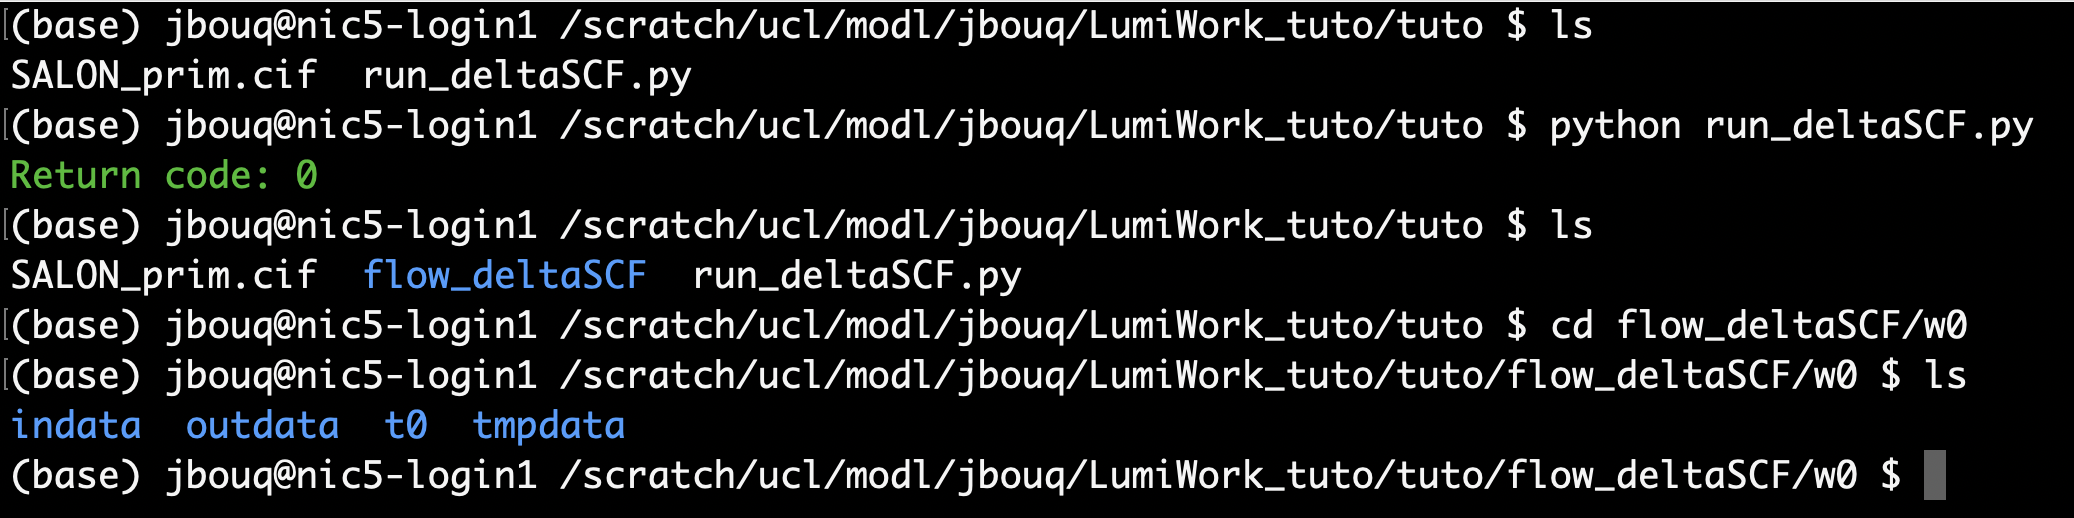

In [27]:
display.Image("IMG/Running_1.png",width=600)


We observe that at this time, only one taks is created, the first ground state relaxation. This is normal since the rest of the workflow will be created at run-time, when the ground state relaxed structure will be extracted. 

Now that the flow is created, we launch the flow with the command :

nohup abirun.py flow_deltaSCF scheduler > log 2> err &


After about one hour, the six abinit tasks are finished :


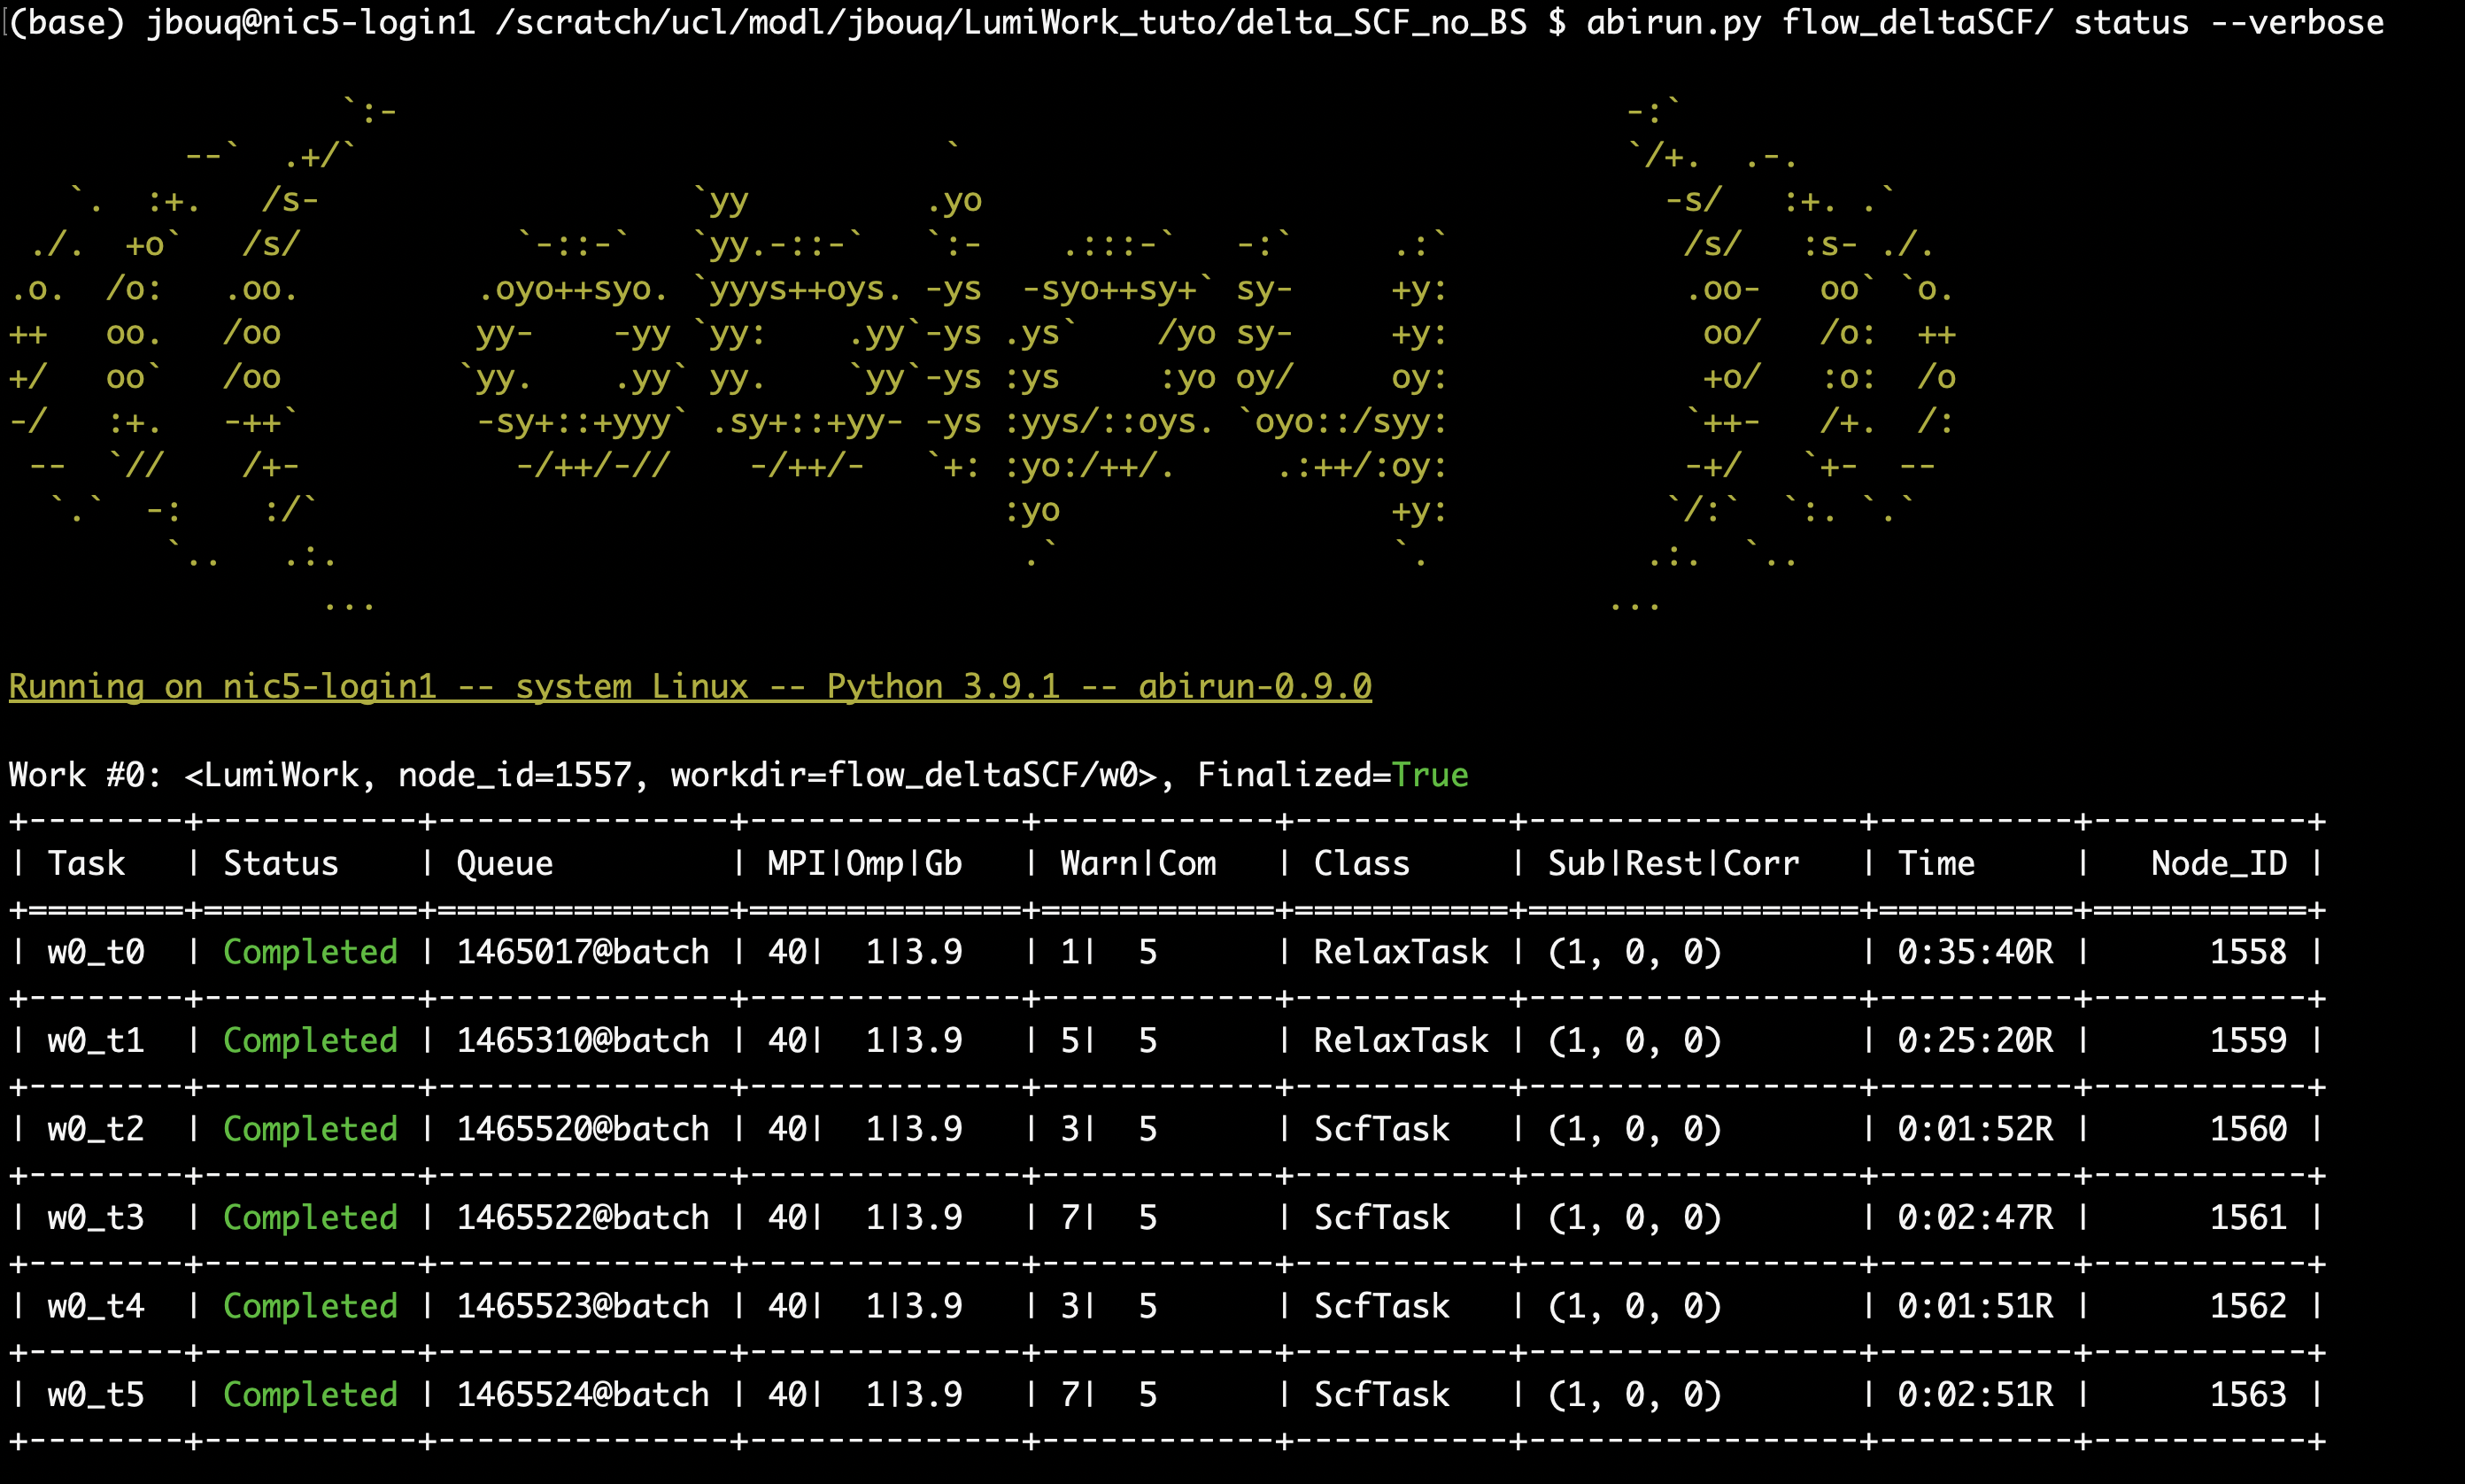

In [28]:
display.Image("IMG/Running_2.png",width=600)


The graphical overview of the workflow looks like : 

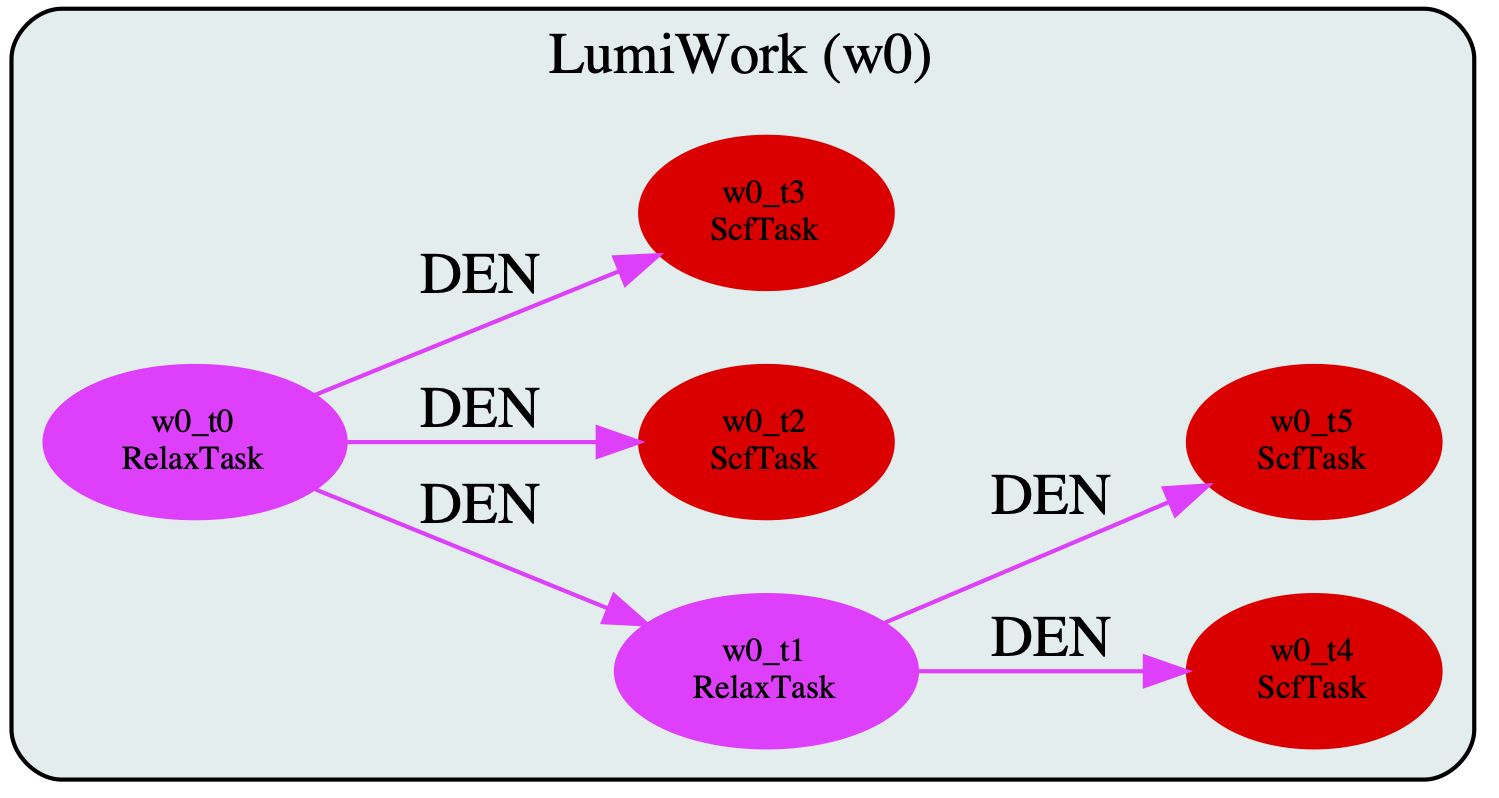

In [29]:
display.Image("IMG/flow.png",width=400)


# Post-processing the results

We now would like to post-process the results of our LumiWork. This can be done with the deltaSCF.py and lineshape.py scripts.

The general philosophy is first to instanciate one DeltaSCF object of the delta_SCF class that we can manipulate thanks to numerous functions.


In [30]:
# We first create a DeltaSCF object (let's call it SALON_object) from the netcdf files (output of Abinit) associated
# to each SCF computations (the four states A_g, A_g_star, A_e_star, A_e , /!\ In this order!!!)

SALON_object=DeltaSCF.from_four_points_file(["flow_deltaSCF/w0/t2/outdata/out_GSR.nc",
                                             "flow_deltaSCF/w0/t3/outdata/out_GSR.nc",
                                             "flow_deltaSCF/w0/t4/outdata/out_GSR.nc",
                                             "flow_deltaSCF/w0/t5/outdata/out_GSR.nc",])

We can access the four state energies, or the two structures :


In [31]:
print(SALON_object.AgEnergy, SALON_object.AgstarEnergy, SALON_object.AestarEnergy, SALON_object.AeEnergy)

-24206.85855050231 eV -24204.726296418663 eV -24204.801479626498 eV -24206.76830522526 eV


In [32]:
print(SALON_object.structure_gs())


Full Formula (Sr7 Li16 Eu1 Al16 N16 O16)
Reduced Formula: Sr7Li16EuAl16(NO)16
abc   :   8.011263   8.011201  12.851616
angles:  90.000000  90.000000  89.711178
Sites (72)
  #  SP            a          b          c  cartesian_forces
---  ----  ---------  ---------  ---------  -----------------------------------------------------------
  0  Eu     0.5       -0          0.125     [-1.93583046e-20 -7.74332184e-20 -7.25936423e-21] eV ang^-1
  1  Sr     0.5       -0          0.37513   [-1.93583046e-20 -7.74332184e-20  6.22059552e-04] eV ang^-1
  2  Sr     0.5       -0          0.625     [-1.93583046e-20 -7.74332184e-20 -7.25936423e-21] eV ang^-1
  3  Sr     0.5       -0          0.87487   [-1.93583046e-20 -7.74332184e-20 -6.22059552e-04] eV ang^-1
  4  Sr    -0          0.5       -1.6e-05   [-1.93583046e-20 -7.74332184e-20  8.96247027e-04] eV ang^-1
  5  Sr    -0          0.5        0.250016  [-1.93583046e-20 -7.74332184e-20 -8.96247027e-04] eV ang^-1
  6  Sr    -0          0.5        0.5000

In [33]:
print(SALON_object.structure_ex())

Full Formula (Sr7 Li16 Eu1 Al16 N16 O16)
Reduced Formula: Sr7Li16EuAl16(NO)16
abc   :   8.011263   8.011201  12.851616
angles:  90.000000  90.000000  89.711178
Sites (72)
  #  SP            a          b          c  cartesian_forces
---  ----  ---------  ---------  ---------  -----------------------------------------------------------
  0  Eu     0.5       -0          0.125     [-1.93583046e-20 -8.71123707e-20 -6.77540661e-20] eV ang^-1
  1  Sr     0.5       -0          0.373304  [-1.93583046e-20 -8.71123707e-20 -5.62255674e-03] eV ang^-1
  2  Sr     0.5       -0          0.625     [-1.93583046e-20 -8.71123707e-20 -6.77540661e-20] eV ang^-1
  3  Sr     0.5       -0          0.876696  [-1.93583046e-20 -8.71123707e-20  5.62255674e-03] eV ang^-1
  4  Sr    -0          0.5       -4.9e-05   [-1.93583046e-20 -8.71123707e-20  1.02256789e-03] eV ang^-1
  5  Sr    -0          0.5        0.250049  [-1.93583046e-20 -8.71123707e-20 -1.02256789e-03] eV ang^-1
  6  Sr    -0          0.5        0.5001

There is one function that computes each informations of the 1D - CCM (transition energies, effective frequencies, Huang Rhys factor, FWHM is the semi-classical approximation,... use the tab to see all the functions)
A recap table of the results within the 1D model can be obtained with the function :


In [34]:
SALON_object.get_dataframe()

,$E_{em}$,$E_{abs}$,$E_{zpl}$,"$E_{FC,g}$","$E_{FC,e}$",$\Delta S$,$\Delta R $,$\Delta Q$,$\hbar\Omega_g$,$\hbar\Omega_e$,$S_{em}$,$S_{abs}$
NaN,1.966826,2.132254,2.057071,0.090245,0.075183,0.165428,0.168425,0.729727,0.037641,0.034357,2.397515,2.188313


One can also visualize the atomic displacement induced by the electronic transition with :

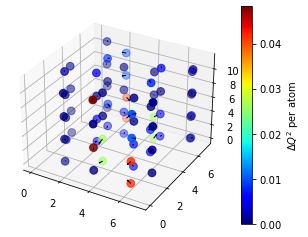

In [35]:
SALON_object.displacements_visu()

Indeed, what we are really interested in is the PL spectrum. To compute it, we need the vibrationnal modes at Gamma of the system under study (here we actually take the undoped system). For this example, we use the DDB file produced by  Abinit phonon computation. 

The input python script allowing this phonon computation (with the help of abipy workflow) is the " run_phonons.py " script. 

From this out_DDB file, we extract the phonon eigenfrequencies and eigenvectors




In [36]:
ddb=abiopen('out_DDB')
ph_gamma=ddb.anaget_phmodes_at_qpoint(qpoint=[0,0,0]) # extracting phonons at Gamma

ph_eigvec=ph_gamma.dyn_mat_eigenvect[0]
ph_eigfreq=ph_gamma.phfreqs[0]

Calculation completed.
Anaddb results available in dir: /var/folders/hf/l45mj5md0tvgm0gb96w50f100000gp/T/tmphcks4_83


/Users/jbouquiaux/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pymatgen/symmetry/kpath.py:180: UserWarning: The input structure does not match the expected standard primitive! The path can be incorrect. Use at your own risk.
  "The input structure does not match the expected standard primitive! "


We then use the lineshape.py script. 
The idea is again to create one Lineshape object (let's call it SALON_lineshape) that we can manipulate with numerous functions. The input parameters of such object are the ZPL energy extracted from the SALON_object, the phonon eigenvectors and eigenfrequencies, and the two relaxed structures (ground and excited) extracted from the SALON_object.

In [37]:
SALON_lineshape=Lineshape(E_zpl=SALON_object.E_zpl(),
                          ph_eigvec=ph_eigvec,
                          ph_eigfreq=ph_eigfreq,
                          structuregs=SALON_object.structure_gs(),
                          structureex=SALON_object.structure_ex())

We can have access to the spectral function of electron-phonon coupling (Partial Huang Rhys factors $S_\nu$) :

In [38]:
S_nu = SALON_lineshape.S_nu()
S_x,S_y = SALON_lineshape.S_hbarOmega(broadening=3)


/Users/jbouquiaux/Desktop/Doctorat/Simulations/LumiWork_tutorial/lineshape.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_nu[i] = np.sum(np.sqrt(masses) * displacements * ph_eigvector[i])


Text(0, 0.5, '$S(\\hbar\\omega)$  (1/eV)')

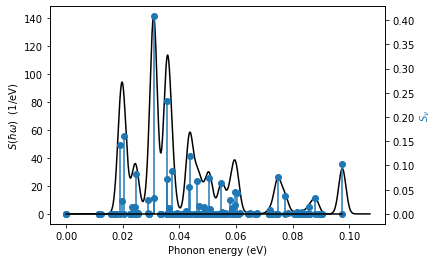

In [39]:
fig, ax1 = plt.subplots()

ax1.plot(S_x,S_y,'k')

ax2 = ax1.twinx()
ax2.stem(ph_eigfreq,S_nu,'tab:blue',basefmt="k")

ax1.set_xlabel('Phonon energy (eV)')
ax2.set_ylabel(r'$S_{\nu}$',color='tab:blue')
ax1.set_ylabel(r'$S(\hbar\omega)$  (1/eV)', color='k')



And ultimately we compute the Luminescence spectrum $L(\hbar\omega)$ at any temperature T computed in an efficient way with a generating function approach

In [40]:
L_x_multi,L_y_multi=SALON_lineshape.L_hw(T=0,lamb=5,w=5,model="multi-D")
L_x_1D,L_y_1D=SALON_lineshape.L_hw(T=0,lamb=5,w=5,model="one-D")

# T is the temperature
# lamb is the Lorentzian broadening lambda in meV
# w is the Gaussian broadening in meV
# model should be either "multi-D" or "one-D"

/Users/jbouquiaux/Desktop/Doctorat/Simulations/LumiWork_tutorial/lineshape.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_nu[i] = np.sum(np.sqrt(masses) * displacements * ph_eigvector[i])


Text(0, 0.5, '$L(\\hbar\\omega)$')

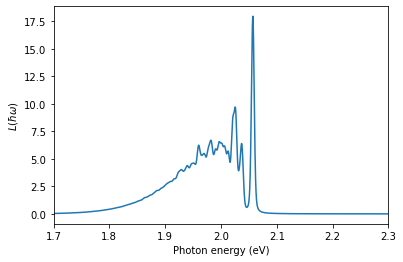

In [41]:
plt.figure()
plt.plot(L_x_multi,L_y_multi,label='multi-D')

plt.xlim(1.7,2.3)
plt.xlabel(r"Photon energy (eV)")
plt.ylabel(r"$L(\hbar\omega)$")


Text(0, 0.5, '$L(\\hbar\\omega)$')

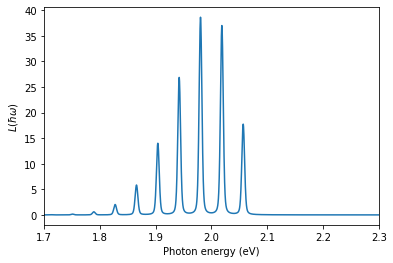

In [42]:
plt.figure()
plt.plot(L_x_1D,L_y_1D,label='one-D')

plt.xlim(1.7,2.3)
plt.xlabel(r"Photon energy (eV)")
plt.ylabel(r"$L(\hbar\omega)$")